In [1]:
using DifferentialEquations
using PyCall
import Random
# using PyPlot
using Statistics
using BenchmarkTools
using Base.Threads
using Plots
import PyPlot
pl = PyPlot;

In [2]:
function KM_model(du, u, p, t)
    
    omega = p[3]
    adj = p[4]
    
    for i = 1:p[2]
        du[i] = omega[i] + p[1] * sum(adj[:, i] .* sin.(u .- u[i]))
    end
    du
end

function sKM_model(du, u, p, t)
    for i = 1:p[2]
        du[i] = p[5]
    end
    du
end

# p = [K[1]/N, N, omega_0, adj, noise_amp]

function order(theta)
    
    n = length(theta)
    
    real_R = 0.0
    imag_R = 0.0
    
    for i = 1:n
        real_R += cos(theta[i])
        imag_R += sin(theta[i])
    end
    
    real_R /= n
    imag_R /= n
    r = sqrt(real_R * real_R + imag_R * imag_R)
    
    return r
end

order (generic function with 1 method)

In [13]:
Random.seed!(1234)

K = 0.5                   
N = 5             
dt = 0.01                    
T = 1000.0                   
T_trans = 0.0                
mu = 1.0                     
sigma = 0.1 
noise_amp = 0.005

p = 0.5
# R = zeros(length(K))

nx = pyimport("networkx")
np = pyimport("numpy")

G = nx.gnp_random_graph(N, p, seed=1)
adj = nx.to_numpy_array(G, dtype=np.int)

ind_transition = Int64(T_trans/dt)
theta_0 = rand(N) .* 2.0 .* pi .- pi
omega_0 = randn(N) .* sigma .+ mu 
tspan = (0.0, T)
p = [K/N, N, omega_0, adj, noise_amp]

prob_sde = SDEProblem(KM_model, sKM_model, theta_0, tspan, p);

In [65]:
# sol= solve(prob_sde, EM(), dt=dt)
# sol = solve(prob_sde, LambaEM());
# sol = solve(prob_sde, EulerHeun(), dt=dt);
# sol = solve(prob_sde, dt=dt);
@btime solve(prob_sde);
@btime solve(prob_sde, EM(), dt=dt)
@btime solve(prob_sde, LambaEM());
@btime solve(prob_sde, EulerHeun(), dt=dt);


  41.846 ms (459866 allocations: 15.02 MiB)
  7.496 ms (84194 allocations: 2.86 MiB)
  1.781 ms (20053 allocations: 688.58 KiB)
  14.831 ms (166279 allocations: 5.51 MiB)


In [66]:
@btime solve(prob_sde, SOSRI(), dt=dt); 

  41.633 ms (463352 allocations: 15.14 MiB)


In [67]:
@btime solve(prob_sde, SOSRA(), dt=dt);

  28.192 ms (311639 allocations: 10.22 MiB)


In [5]:
function plot_r(sol, ax)
    nstep = length(sol.t)
    r = zeros(nstep)
    for j =1:nstep
        r[j] = order(sol.u[j])
    end
#     println(mean(r), " ", length(sol.t))
    ax.plot(sol.t, r);
end

# plot_r(sol);
# plot_phases(sol);

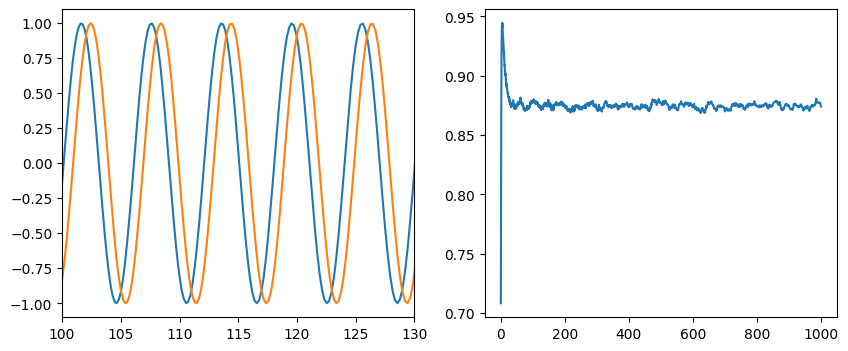

In [20]:
sol= solve(prob_sde, SOSRA(), dt=dt)
fig, ax = pl.subplots(ncols=2, nrows=1, figsize=(10, 4))
phases = hcat(sol.u...);

for i =1:2
    ax[1].plot(sol.t, sin.(phases[i, :]))
end
plot_r(sol, ax[2])
ax[1].set_xlim(100, 130)
pl.show();

In [21]:
# println(typeof(sol.u))
# println(length(sol.u))
# println(length(sol.u[1]))
# phases = hcat(sol.u...)
# println(size(phases))
# println(typeof(phases))
# println(size(phases[1, :]))

Array{Array{Float64,1},1}
150002
50
(50, 150002)
Array{Float64,2}
(150002,)


In [6]:
# plot(sol, vars=(1, 2))

In [7]:
nthreads()

1

In [ ]:
# sol = solve(prob_sde, EM(), dt=dt);

# nstep = length(sol.t)
# r = zeros(nstep)
# for j =1:nstep
#     r[j] = order(sol.u[j])
# end
# println(mean(r))
# println(length(sol.t))